# AdventureWorks - Försäljningsanalys

Analysen undersöker följande frågor:
1. Hur många produkter finns i varje kategori?
2. Vilka produktkategorier genererar mest intäkter?
3. Hur har försäljningen utvecklats över tid?
4. Hur ser total försäljning och antal ordrar ut per år?
5. Vilka 10 produkter genererar mest försäljning?
6. Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?
7. Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

Dessutom görs en djupanalys av den regionala försäljningen med syfte att hitta sätt att optimera den.

Data bearbetas med SQL och visualiseras och analyseras med Python.


In [19]:
import pyodbc
import pandas as pd 
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import matplotlib.pyplot as plt
import numpy as np 

In [20]:
user = "SA"
password = quote_plus("!Kattluva2025")
server = "localhost:1433"
database = "AdventureWorks2025"
driver = quote_plus("ODBC Driver 18 for SQL server")

connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)

try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\malin\AppData\Local\Temp\ipykernel_24240\1196406048.py:15: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [21]:
def query_df(sql: str) -> pd.DataFrame: 
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualisering 1: Antal produkter per kategori
**Affärsfråga:** Hur många produkter finns i varje kategori?

**Tabeller som används**:  
Production.ProductCategory  
Production.ProductSubcategory  
Production.Product  

**Plan**:  
JOINa tabellerna  
Räkna DISTINCT produkter per kategori  
Skapa vertiklat stapeldiagram  
Analysera resultatet  

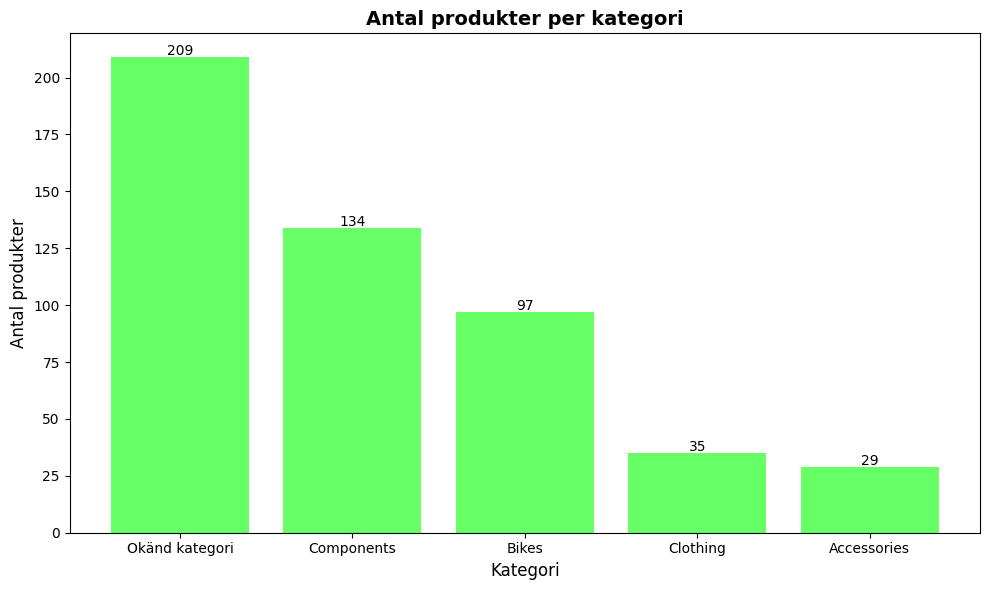

In [6]:
query_vis1 = """
SELECT
    COALESCE(pc.Name, 'Okänd kategori') AS Category,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.Product AS p
LEFT JOIN Production.ProductSubcategory AS ps
    ON p.ProductSubcategoryID = ps.ProductSubcategoryID
LEFT JOIN Production.ProductCategory AS pc
    ON ps.ProductCategoryID = pc.ProductCategoryID
GROUP BY COALESCE(pc.Name, 'Okänd kategori')
ORDER BY ProductCount DESC;
"""
df_vis1 = query_df(query_vis1)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(df_vis1["Category"], df_vis1["ProductCount"], color="lime", alpha=0.6)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 2.5,
        f"{int(height)}",
        va="center",
        ha="center"
    )

ax.set_title("Antal produkter per kategori", fontsize=14, fontweight="bold")
ax.set_xlabel("Kategori", fontsize=12)  
ax.set_ylabel("Antal produkter", fontsize=12)

plt .tight_layout()
plt.show()

### Insikter
Flest unika produkter finns i kategorin Components med 134 stycken vilket indikerar att företaget har ett fokus på komponenter och reservdelar.  
Den minsta kategorin är Accessories med 29 produkter. Detta kan vara ett utvecklingsområde.  

Det finns också ett stort antal unika produkter, 209 stycken, som saknar klassificering.  
_____________________________________________________________________________________________________________________________________________________

## Visualisering 2: Försäljning per produktkategori
**Affärsfråga:** Vilka produktkategorier genererar mest intäkter?

**Tabeller som används:**  
Production.ProductCategory  
Production.ProductSubcategory  
Production.Product  
Sales.SalesOrderDetail  

**Plan:**  
JOINa tabellerna  
Räkna intäkt per kategori  
Skapa horisontellt stapeldiagram  
Analysera resultatet 

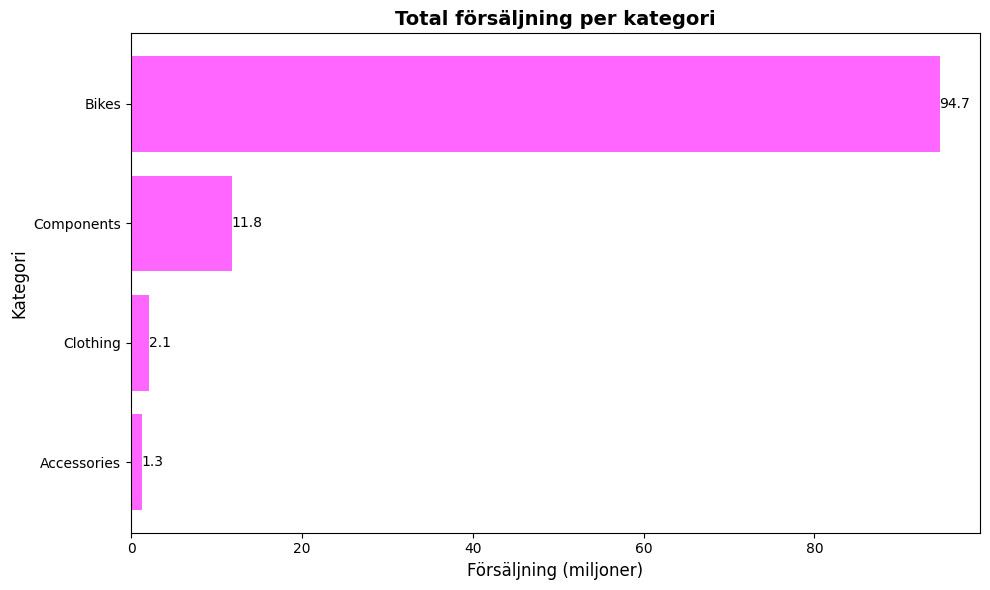

In [7]:
query_vis2 = """
SELECT 
    pc.Name AS Category,
    SUM(sod.LineTotal) AS TotalSales
FROM Production.ProductCategory AS pc
JOIN Production.ProductSubcategory AS psc
    ON pc.ProductCategoryID = psc.ProductCategoryID
JOIN Production.Product AS p
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
JOIN Sales.SalesOrderDetail AS sod
    ON p.ProductID = sod.ProductID 
GROUP BY pc.Name
ORDER BY TotalSales DESC;
"""
df_vis2 = query_df(query_vis2)
df_vis2 = df_vis2.sort_values("TotalSales", ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(df_vis2["Category"], df_vis2["TotalSales"] / 1_000_000, color="magenta", alpha=0.6)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height()/2,
        f"{width:,.1f}",
        va="center",
        ha="left"
    )

ax.set_title("Total försäljning per kategori", fontsize=14, fontweight="bold")
ax.set_xlabel("Försäljning (miljoner)", fontsize=12)
ax.set_ylabel("Kategori", fontsize=12)

plt.tight_layout()
plt.show()

### Insikter
Den produktkategori som genererar mest intäkter är Bikes med cirka 94,7 miljoner medan minst intäkt genereras av kategorin Accessories med cirka 1,3 miljoner.  

Kontroll har gjorts av att det inte finns någon intäkt i kategori Okänd. Intäkt är beräknad utan hänsyn till valutan.  
Försäljning förekommer i form av kanadensisk dollar, australisk dollar, EURO, brittiskt pund, tysk mark och fransk franc,  
men då de ligger inom samma storleksordning och antas därför inte påverkar jämförelsen mellan produktkategorier.  
_____________________________________________________________________________________________________________________________________________________

## Visualisering 3: Försäljningstrend över tid
**Affärsfråga:** Hur har försäljningen utvecklats över tid?  

**Tabeller som sanvänds:**
Sales.SalesOrderHeader

**Plan:**
Aggregera försäljning per månad för åren med helårsdata, 2023 och 2024  
Skapa linjediagram med trendlinje  
Plocka ut månad med lägst respektive högst försäljning  
Gruppera månaderna för en djupare analys av säsongsmönster  
Analysera resultatet  


Månad med lägst försäljning: 2023-02
Månad med högsta försäljning: 2024-06


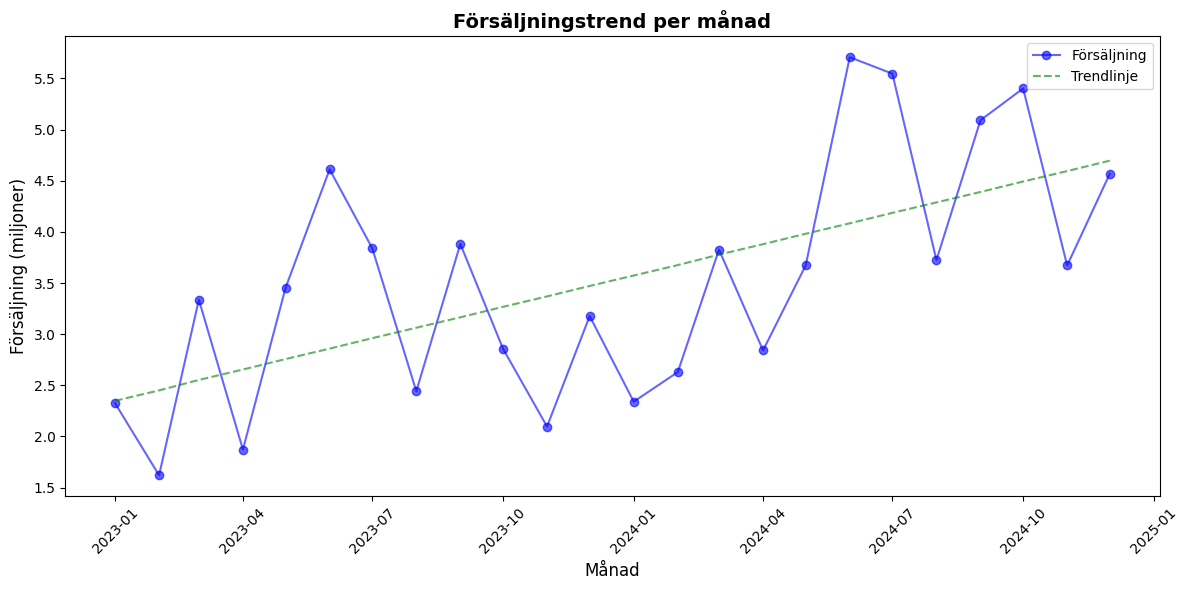

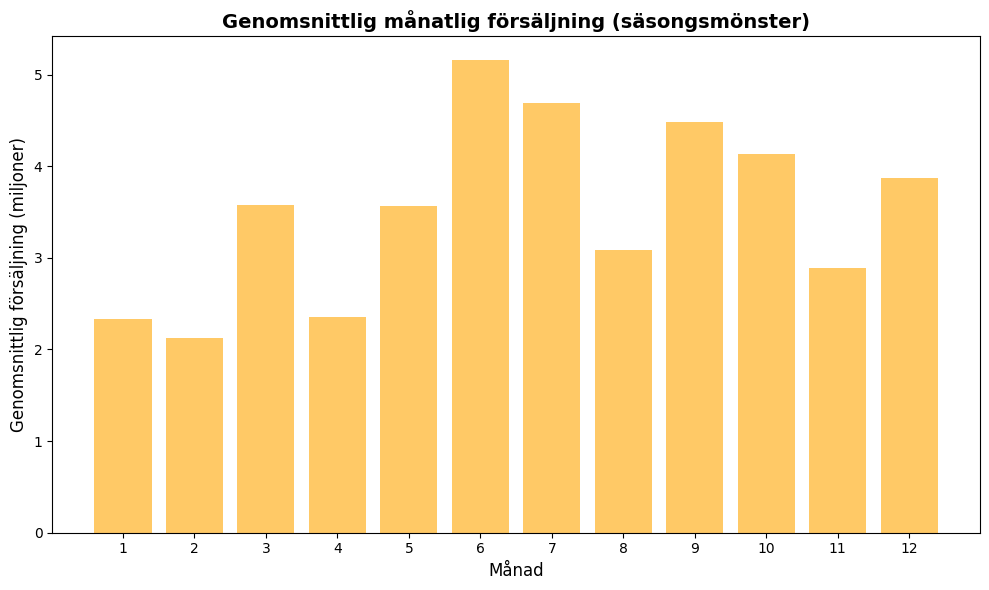

In [8]:
query_vis3 = """
SELECT 
    FORMAT(soh.OrderDate, 'yyyy-MM') AS OrderMonth,
    SUM(soh.TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader AS soh
WHERE OrderDate >= '2023-01-01' AND OrderDate <  '2025-01-01'
GROUP BY FORMAT(soh.OrderDate, 'yyyy-MM')
ORDER BY OrderMonth ASC;
"""
df_vis3 = query_df(query_vis3)

# Identifiera månader med lägst och högst försäljning
df_vis3["OrderMonth"] = pd.to_datetime(df_vis3["OrderMonth"], format="%Y-%m")
df_vis3["TotalSales"] = pd.to_numeric(df_vis3["TotalSales"])
min_row = df_vis3.loc[df_vis3["TotalSales"].idxmin()]
max_row = df_vis3.loc[df_vis3["TotalSales"].idxmax()]

print(
    f"Månad med lägst försäljning: {min_row['OrderMonth'].strftime('%Y-%m')}\n"
    f"Månad med högsta försäljning: {max_row['OrderMonth'].strftime('%Y-%m')}"
)

# Trendanalys
x = np.arange(len(df_vis3))
y = df_vis3["TotalSales"] / 1_000_000
coef = np.polyfit(x, y, 1)
trend = np.poly1d(coef)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_vis3["OrderMonth"], df_vis3["TotalSales"] / 1_000_000, marker="o", linestyle="-", color="blue", alpha=0.6, label="Försäljning")
ax.plot(df_vis3["OrderMonth"], trend(x), linestyle="--", color="green", alpha=0.6, label="Trendlinje")

ax.set_title("Försäljningstrend per månad", fontsize=14, fontweight="bold")
ax.set_xlabel("Månad", fontsize=12)
ax.set_ylabel("Försäljning (miljoner)", fontsize=12)
ax.tick_params(axis="x", rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

# Säsongsmönster
df_vis3["OrderMonth"] = pd.to_datetime(df_vis3["OrderMonth"])

df_vis3["Month"] = df_vis3["OrderMonth"].dt.month
seasonality = (
    df_vis3.groupby("Month")["TotalSales"]
      .mean()
      .reset_index()
)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(seasonality["Month"], seasonality["TotalSales"] / 1_000_000, color="orange", alpha=0.6)

ax.set_title("Genomsnittlig månatlig försäljning (säsongsmönster)", fontsize=14, fontweight="bold")
ax.set_xlabel("Månad", fontsize=12)
ax.set_ylabel("Genomsnittlig försäljning (miljoner)", fontsize=12)
ax.set_xticks(seasonality["Month"])

plt.tight_layout()
plt.show()

### Insikter
Försäljningen uppvisar en tydligt ökande trend över tid under perioden 2023–2024, vilket framgår av trendlinjen i det diagrammet Försäljningstrend per månad.  
Månaden med lägst försäljning är februari 2023, medan juni 2024 har högst försäljning under perioden.  

Analysen av genomsnittlig försäljning per kalendermånad visar även ett säsongsmönster, där försäljningen generellt är högre under sommarmånaderna, särskilt i juni,  
medan lägre nivåer återkommer under vissa vintermånader. Detta indikerar att försäljningen följer säsonger då det är bättre förutsättningar för att cykla och den relativst höga försäljningen i december kan vara kopplad till julhandeln.
_____________________________________________________________________________________________________________________________________________________

# Visualisering 4: Försäljning och antal ordrar per år
**Affärsfråga:** Hur ser total försäljning och antal ordrar ut per år?

**Tabeller som används:**  
Sales.SalesOrderHeader

**Plan:**  
Summera total försäljning  
Räkna antal ordrar  
Gruppera på år  
Skapa grupperat stapeldiagram  

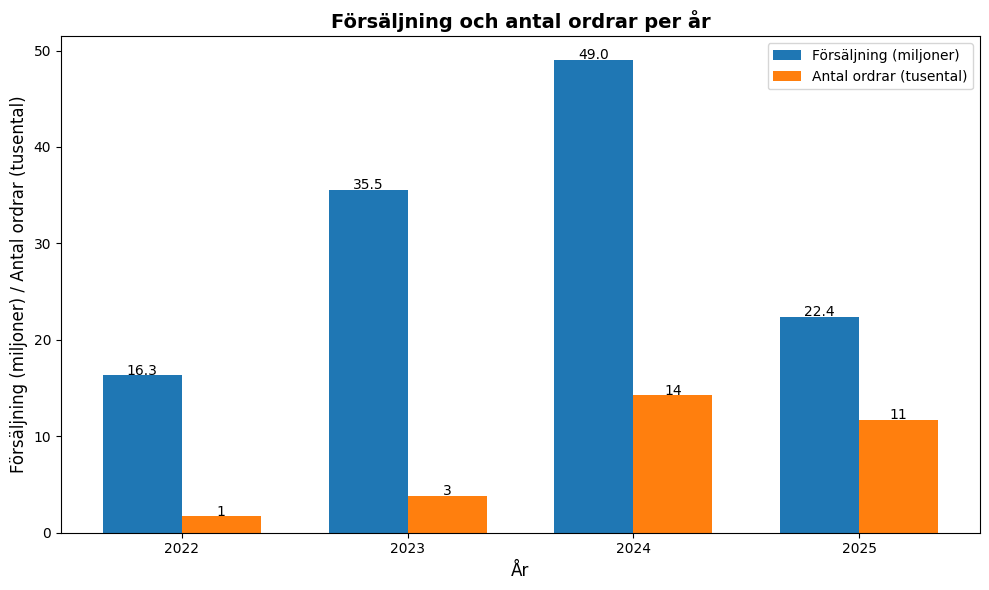

In [9]:
query_vis4 = """
SELECT 
    YEAR(soh.OrderDate) AS OrderYear,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(soh.SalesOrderID) AS OrderCount
FROM Sales.SalesOrderHeader AS soh
GROUP BY YEAR(soh.OrderDate)
ORDER BY OrderYear;
"""

df_vis4 = query_df(query_vis4) 

x = np.arange(len(df_vis4))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars_sales = ax.bar(x - width/2, df_vis4["TotalSales"] / 1_000_000, width, label="Försäljning (miljoner)")
bars_orders = ax.bar(x + width/2, df_vis4["OrderCount"] / 1_000, width, label="Antal ordrar (tusental)")

for bar in bars_sales:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.5,
        f"{height:,.1f}",
        va="center",
        ha="center"
    )

for bar in bars_orders:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.5,
        f"{int(height)}",
        va="center",
        ha="center"
    )

ax.set_title("Försäljning och antal ordrar per år", fontsize=14, fontweight="bold")
ax.set_xlabel("År", fontsize=12)
ax.set_ylabel("Försäljning (miljoner) / Antal ordrar (tusental)", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(df_vis4["OrderYear"])

ax.legend()
plt.tight_layout()
plt.show()

### Insikter
Diagrammet visar att både försäljning och antal ordrar ökar från 2022 till 2024, med 2024 som det hittills starkaste året sett till både total försäljning och antal ordrar.  
Under 2024 uppgår försäljningen till cirka 49 miljoner, samtidigt som antalet ordrar är som högst, cirka 14 tusen.

År 2022 har lägst försäljning och lägst antal ordrar, medan 2023 visar en tydlig ökning jämfört med föregående år.  
För 2025 ses en nedgång i både försäljning och antal ordrar, vilket sannolikt beror på att året inte representerar en fullständig försäljningsperiod.
_____________________________________________________________________________________________________________________________________________________

## Visualisering 5: Top 10 produkter
**Affärsfråga:** Vilka 10 produkter genererar mest försäljning?

**Tabeller som används:**  
Production.Product  
Sales.SalesOrderDetail  

**Plan:**  
JOINa tabellerna  
Välja top 10  
Sortera på försäljning  
Skapa horisontellt stapeldiagram  
Analysera resultatet

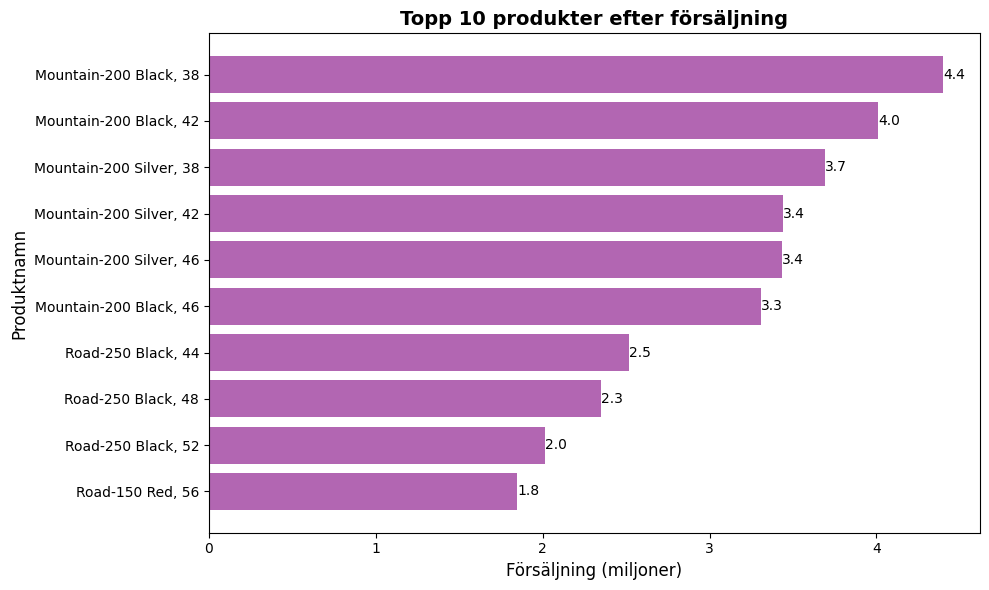

In [10]:
query_vis5 = """
SELECT TOP 10
    p.Name AS ProductName,
    SUM(sod.LineTotal) AS TotalSales
FROM Production.Product AS p
JOIN Sales.SalesOrderDetail AS sod
    ON p.ProductID = sod.ProductID
GROUP BY p.Name
ORDER BY TotalSales DESC;
"""

df_vis5 = query_df(query_vis5)
df_vis5 = df_vis5.sort_values("TotalSales", ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(df_vis5["ProductName"], df_vis5["TotalSales"] / 1_000_000, color="purple", alpha=0.6)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height()/2,
        f"{width:,.1f}",
        va="center",
        ha="left"
    )  

ax.set_title("Topp 10 produkter efter försäljning", fontsize=14, fontweight="bold")
ax.set_xlabel("Försäljning (miljoner)", fontsize=12)
ax.set_ylabel("Produktnamn", fontsize=12)

plt.tight_layout()
plt.show()

### Insikter
Analysen visar att Mountain-200-modellerna dominerar försäljningen, där Mountain-200 Black, 38 är den enskilda produkt som genererar högst intäkt med cirka 4,4 miljoner.  
Även övriga varianter inom Mountain-200-serien återfinns högt i rankingen, vilket indikerar att denna produktserie står för en betydande del av den totala försäljningen.

Bland de tio mest sålda produkterna återfinns även Road-modeller, men dessa genererar genomgående lägre intäkter jämfört med Mountain-200-produkterna.  
Den produkt med lägst försäljning inom topp-10-listan är Road-150 Red, 56, med cirka 1,8 miljoner i total försäljning.
_____________________________________________________________________________________________________________________________________________________

## Visualisering 6: Försäljning och antal kunder per region
**Affärsfråga:** Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

**Tabeller som används:**  
Sales.SalesTerritory  
Sales.SalesOrderHeader  
Sales.Customer

**Plan:** 
JOINa tabellerna  
Summera försäljning  
Räkna antal kunder  
Gruppera på region   
Sortera på försäljning  
Skapa grupperat stapeldiagram  
Analysera resultatet

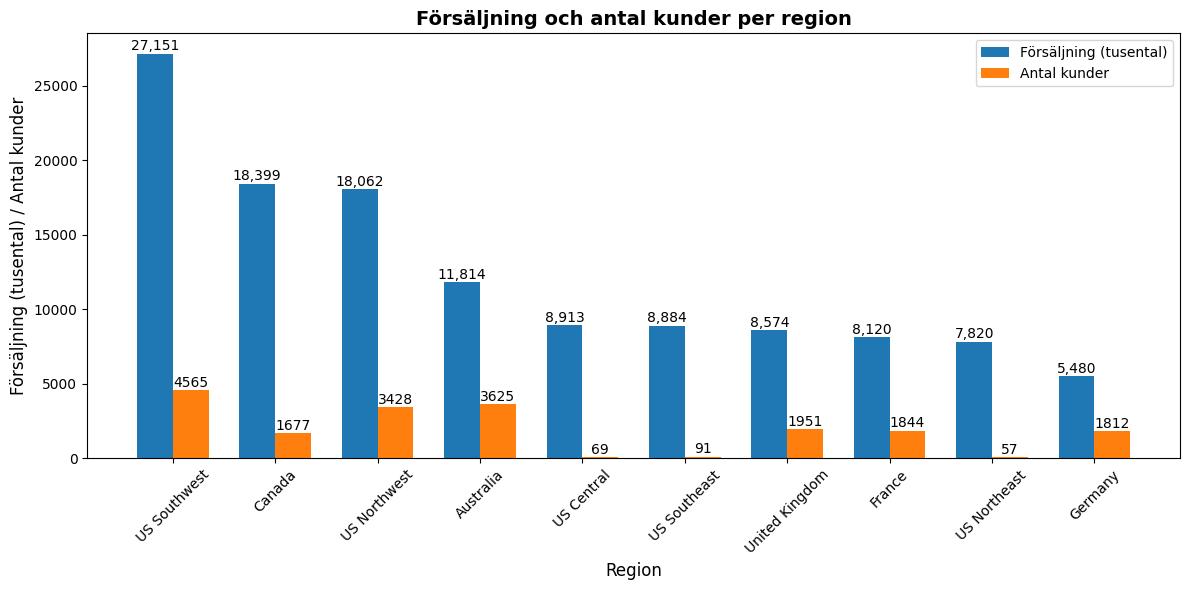

In [11]:
query_vis6 = """
SELECT
    CASE
        WHEN st.CountryRegionCode = 'US'
            THEN CONCAT('US ',st.Name)
        ELSE st.Name
    END AS Region,
    COUNT(DISTINCT c.CustomerID) AS UniqueCustomers,
    SUM(soh.TotalDue) AS TotalSales
FROM Sales.SalesTerritory AS st
LEFT JOIN Sales.SalesOrderHeader AS soh
    ON st.TerritoryID = soh.TerritoryID
LEFT JOIN Sales.Customer AS c
    ON soh.CustomerID = c.CustomerID
GROUP BY
    CASE
        WHEN st.CountryRegionCode = 'US'
            THEN CONCAT('US ',st.Name)
        ELSE st.Name
    END
ORDER BY TotalSales DESC;
"""

df_vis6 = query_df(query_vis6)

x = np.arange(len(df_vis6))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars_sales = ax.bar(x - width/2, df_vis6["TotalSales"] / 1_000, width, label="Försäljning (tusental)")
bars_customers = ax.bar(x + width/2, df_vis6["UniqueCustomers"], width, label="Antal kunder")

for bar in bars_sales:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 500,
        f"{height:,.0f}",
        va="center",
        ha="center"
    )

for bar in bars_customers:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 500,
        f"{int(height)}",
        va="center",
        ha="center"
    )

ax.set_title("Försäljning och antal kunder per region", fontsize=14, fontweight="bold")
ax.set_xlabel("Region", fontsize=12)
ax.set_ylabel("Försäljning (tusental) / Antal kunder", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(df_vis6["Region"], rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

### Insikter
Analysen visar att US Southwest är den region som genererar högst försäljning, med cirka 27 miljoner, och har samtidigt flest kunder, omkring 4,5 tusen.  
Därefter följer Canada och US Northwest, som båda uppvisar relativt hög försäljning men med färre kunder jämfört med US Southwest.

Germany och US Northeast tillhör de regioner som har lägst försäljning och färre kunder.  

Sammantaget indikerar detta att både kundbasens storlek och regional efterfrågan bidrar till skillnaderna i försäljning mellan regionerna.
_____________________________________________________________________________________________________________________________________________________

## Visualisering 7: Genomsnittligt ordervärde per region och kundtyp
**Affärsfråga:** Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

**Tabeller som används:**  
Sales.SalesTerritory  
Sales.SalesOrderHeader  
Sales.Customer  
Sales.Store

**Plan:**  
JOINa tabellerna  
Summera försäljning för individuella kunder respektive företagskunder  
Räkna antal ordrar för individuella kunder respektive företagskunder
Dela försäljning med antal ordrar individuella kunder respektive företagskunder  
Gruppera på region   
Sortera på totalt genomsnittligt ordervärde  
Skapa grupperat stapeldiagram  
Analysera resultatet

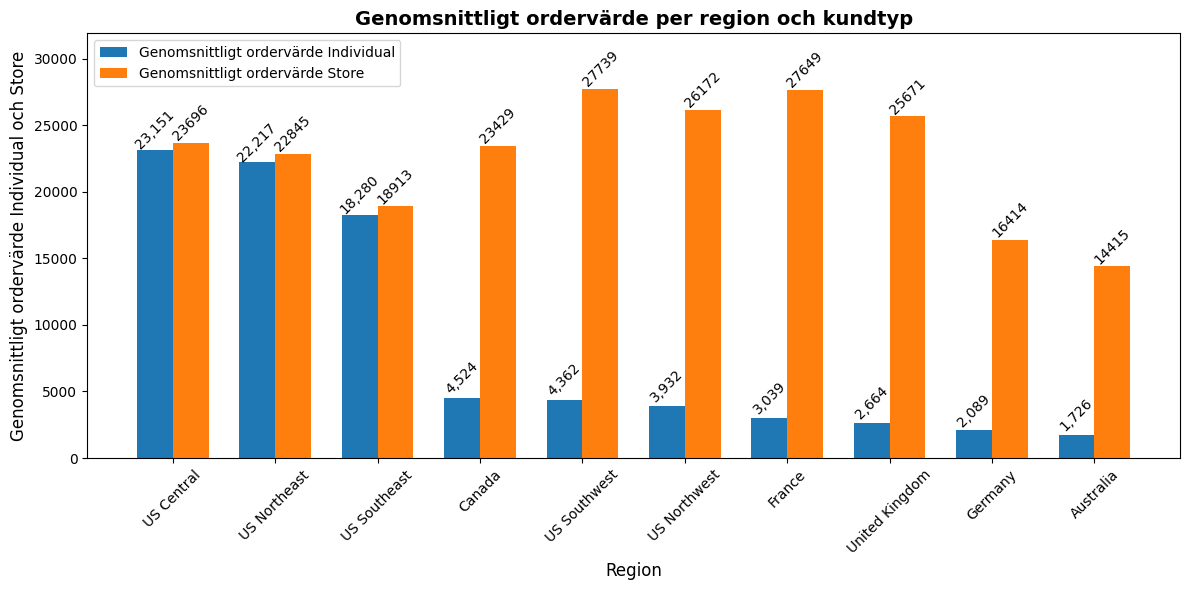

In [13]:
query_vis7 = """
SELECT
    CASE
        WHEN st.CountryRegionCode = 'US'
            THEN CONCAT('US ',st.Name)
        ELSE st.Name
    END AS Region,
    SUM(CASE 
            WHEN c.PersonID IS NOT NULL THEN soh.TotalDue 
            ELSE 0 
        END) / NULLIF(COUNT(CASE 
            WHEN c.PersonID IS NOT NULL THEN soh.SalesOrderID 
            ELSE NULL 
        END), 0) AS AvgIndividualOrderValue,
    SUM(CASE 
            WHEN c.StoreID IS NOT NULL THEN soh.TotalDue 
            ELSE 0 
        END) / NULLIF(COUNT(CASE 
            WHEN c.StoreID IS NOT NULL THEN soh.SalesOrderID 
            ELSE NULL 
        END), 0) AS AvgStoreOrderValue,
    SUM(soh.TotalDue) / NULLIF(COUNT(DISTINCT soh.SalesOrderID), 0) AS AvgTotalOrderValue
FROM Sales.SalesTerritory AS st
LEFT JOIN Sales.SalesOrderHeader AS soh
    ON st.TerritoryID = soh.TerritoryID
LEFT JOIN Sales.Customer AS c
    ON soh.CustomerID = c.CustomerID
LEFT JOIN Sales.Store AS s
    ON c.StoreID = s.BusinessEntityID
GROUP BY
    CASE
        WHEN st.CountryRegionCode = 'US'
            THEN CONCAT('US ',st.Name)
        ELSE st.Name
    END
ORDER BY AvgTotalOrderValue DESC;
"""

df_vis7 = query_df(query_vis7)

x = np.arange(len(df_vis7))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars_individual = ax.bar(x - width/2, df_vis7["AvgIndividualOrderValue"], width, label="Genomsnittligt ordervärde Individual")
bars_store = ax.bar(x + width/2, df_vis7["AvgStoreOrderValue"], width, label="Genomsnittligt ordervärde Store")

for bar in bars_individual:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 1500,
        f"{height:,.0f}",
        va="center",
        ha="center",
        rotation=45
    )

for bar in bars_store:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 1500,
        f"{int(height)}",
        va="center",
        ha="center",
        rotation=45
    )

ax.set_title("Genomsnittligt ordervärde per region och kundtyp", fontsize=14, fontweight="bold")
ax.set_xlabel("Region", fontsize=12)
ax.set_ylabel("Genomsnittligt ordervärde Individual och Store", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(df_vis7["Region"], rotation=45)
ax.margins(y=0.15)

ax.legend()
plt.tight_layout()
plt.show()


### Insikter
Analysen visar att företagskunder (Store) genomgående har ett högre genomsnittligt ordervärde än individuella kunder i samtliga regioner. Skillnaden är särskilt tydlig i regioner som US Southwest, France och United Kingdom, där företagskundernas genomsnittliga ordervärde är flera gånger högre än motsvarande värde för privatkunder.

Det högsta genomsnittliga ordervärdet återfinns för företagskunder i US Southwest, med cirka 27 700, följt av France och US Northwest på liknande nivåer. För individuella kunder är det istället US Central och US Northeast som uppvisar de högsta genomsnittliga ordervärdena, båda kring 22 000–23 000.

Lägst genomsnittligt ordervärde återfinns för individuella kunder i Australia, med cirka 1 700, medan företagskunder i Australia också tillhör de lägre nivåerna jämfört med övriga regioner. Sammantaget indikerar resultatet att företagskunder generellt lägger större och mer värdefulla ordrar än privatkunder, samt att skillnaden mellan kundtyper varierar tydligt mellan regioner, sannolikt beroende på marknadsstruktur och kundbeteende.
 
_____________________________________________________________________________________________________________________________________________________

## Visualisering VG1: Regional försäljningsoptimering
**Affärsfråga:** Vilken region presterar bäst/sämst?

**Tabeller som används:**  
Sales.SalesTerritory  
Sales.SalesOrderHeader  

**Plan:**  
JOINa tabellerna  
Summera total försäljning  
Räkna antal ordrar  
Beräkna genomsnittligt ordervärde  
Gruppera på region   
Sortera på totalt genomsnittligt ordervärde  
Skapa grupperat stapeldiagram  
Analysera resultatet

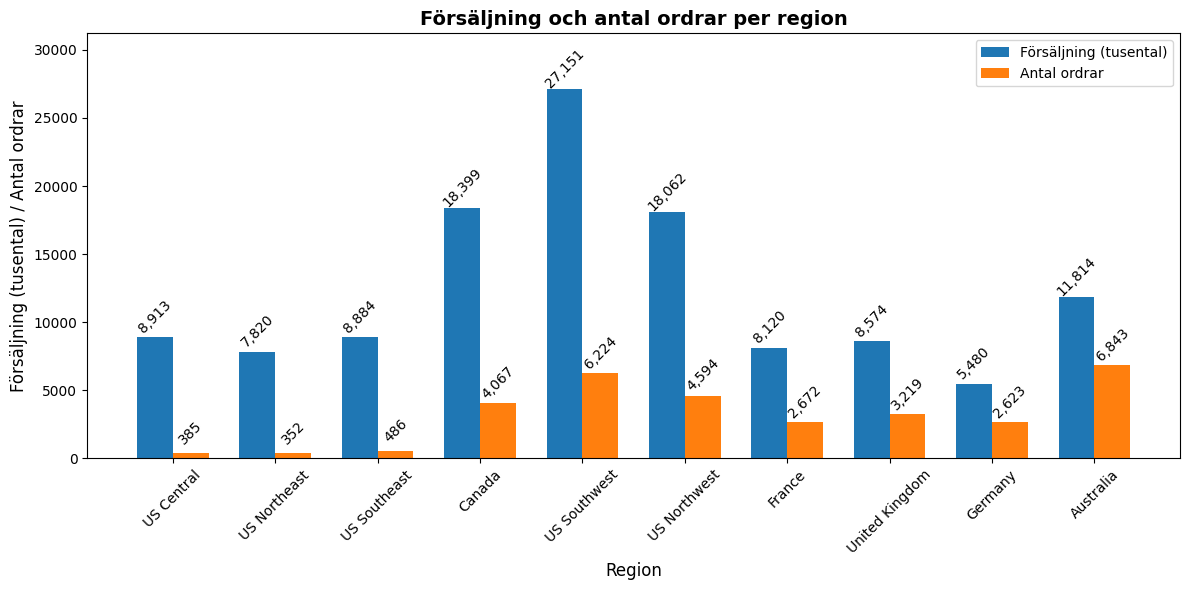

In [12]:
query_visVG1 = """
SELECT
    CASE
        WHEN st.CountryRegionCode = 'US'
            THEN CONCAT('US ',st.Name)
        ELSE st.Name
    END AS Region,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(DISTINCT soh.SalesOrderID) AS NumberOfOrders,
    SUM(soh.TotalDue) / NULLIF(COUNT(DISTINCT soh.SalesOrderID), 0) AS AvgTotalOrderValue
FROM Sales.SalesTerritory AS st
LEFT JOIN Sales.SalesOrderHeader AS soh
    ON st.TerritoryID = soh.TerritoryID
GROUP BY
    CASE
        WHEN st.CountryRegionCode = 'US'
            THEN CONCAT('US ',st.Name)
        ELSE st.Name
    END
ORDER BY AvgTotalOrderValue DESC;
"""

df_visVG1 = query_df(query_visVG1)

x = np.arange(len(df_visVG1))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars_sales = ax.bar(x - width/2, df_visVG1["TotalSales"] / 1_000, width, label="Försäljning (tusental)")
bars_orders = ax.bar(x + width/2, df_visVG1["NumberOfOrders"], width, label="Antal ordrar")

for bar in bars_sales:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 1500,
        f"{height:,.0f}",
        va="center",
        ha="center",
        rotation=45
    )

for bar in bars_orders:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 1500,
        f"{height:,.0f}",
        va="center",
        ha="center",
        rotation=45
    )

ax.set_title("Försäljning och antal ordrar per region", fontsize=14, fontweight="bold")
ax.set_xlabel("Region", fontsize=12)
ax.set_ylabel("Försäljning (tusental) / Antal ordrar", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(df_visVG1["Region"], rotation=45)
ax.margins(y=0.15)

ax.legend()
plt.tight_layout()
plt.show()

### Insikter
Till skillnad från analysen av total försäljning i visualisering 6 är regionerna här sorterade efter genomsnittligt ordervärde, vilket ger ett annat perspektiv på prestation.  
Det jämför regionernas effektivitet per order, inte deras totala volym.

Regionen US Southwest presterar bäst sett till total försäljning och har även det näst högsta antalet ordrar, vilket indikerar både hög efterfrågan och stor marknadsvolym.  
Regionen Germany presterar sämst med lägst försäljning, trots ett relativt högt antal ordrar jämfört med vissa andra regioner.  
Lägst genomsnittligt ordervärde har Australia som samtidigt har det högsta antalet ordrar.  

Sammantaget visar detta att hög prestation kan bero på olika faktorer – antingen många ordrar, högt ordervärde, eller en kombination av båda. 
__________________________________________________________________________________________________________________________________________

## Visualisering VG2: Regional försäljningsoptimering
**Affärsfråga:** Vilka produktkategorier säljer bäst var?

**Tabeller som används:**  
Sales.SalesTerritory  
Sales.SalesOrderHeader  
Sales.SalesOrderDetail   
Production.Product  
Production.ProductSubcategory  
Production.ProductCategory  

**Plan:** 
JOINa tabellerna
Summera total försäljning
Gruppera per region  
Sortera på total försäljning  
Skapa pivotabell  
Skapa heatmap
Analysera resultatet

Category,Accessories,Bikes,Clothing,Components
Region,,,,
US Southwest,253819.848931,2.080367e+07,434914.615123,2.692201e+06
US Northwest,163069.765932,1.388202e+07,256254.571338,1.783595e+06
Canada,221505.198138,1.345768e+07,432112.252376,2.244470e+06
Australia,162638.160108,1.017587e+07,113175.753662,2.036513e+05
US Central,46296.637372,6.761070e+06,154237.590702,9.474048e+05
US Southeast,45749.328311,6.710273e+06,164334.451199,9.592981e+05
United Kingdom,119223.067944,6.688590e+06,151068.307075,7.118398e+05
France,111438.507094,6.114241e+06,155127.441067,8.707483e+05
US Northeast,51001.715060,5.675571e+06,161203.625894,1.051598e+06


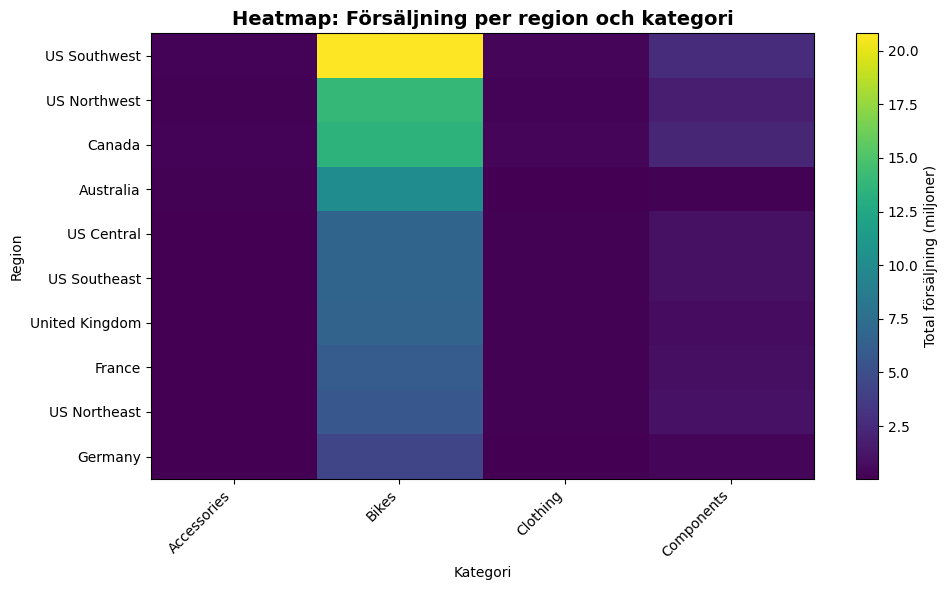

In [28]:
query_visVG2 = """
SELECT
    CASE
        WHEN st.CountryRegionCode = 'US'
            THEN CONCAT('US ',st.Name)
        ELSE st.Name
    END AS Region,
    pc.Name AS Category,
    SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesTerritory AS st
LEFT JOIN Sales.SalesOrderHeader AS soh
    ON st.TerritoryID = soh.TerritoryID
LEFT JOIN Sales.SalesOrderDetail AS sod
    ON soh.SalesOrderID = sod.SalesOrderID
LEFT JOIN Production.Product AS p
    ON sod.ProductID = p.ProductID
LEFT JOIN Production.ProductSubcategory AS ps
    ON p.ProductSubcategoryID = ps.ProductSubcategoryID
LEFT JOIN Production.ProductCategory AS pc
    ON ps.ProductCategoryID = pc.ProductCategoryID
WHERE sod.LineTotal IS NOT NULL
GROUP BY 
    CASE
        WHEN st.CountryRegionCode = 'US'
            THEN CONCAT('US ',st.Name)
        ELSE st.Name
    END,
    pc.Name
ORDER BY TotalSales DESC;
"""

df_visVG2 = query_df(query_visVG2)

piv = pd.pivot_table(
    df_visVG2,
    index="Region",
    columns="Category",
    values="TotalSales",
    aggfunc="sum",
    fill_value=0,
    observed = True
).sort_values(by="Bikes", ascending=False)

display(piv)

piv_plot = piv / 1_000_000

fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(piv_plot.values, aspect="auto")

ax.set_xticks(range(len(piv_plot.columns)))
ax.set_xticklabels(piv_plot.columns, rotation=45, ha="right")

ax.set_yticks(range(len(piv_plot.index)))
ax.set_yticklabels(piv_plot.index)

ax.set_title("Heatmap: Försäljning per region och kategori", fontsize=14, fontweight="bold")
ax.set_xlabel("Kategori")
ax.set_ylabel("Region")

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Total försäljning (miljoner)", rotation=90)

plt.tight_layout()
plt.show()

### Insikter
_____________________________________________________________________________________________________________________________________________________

## Visualisering VG3: Regional försäljningsoptimering
**Affärsfråga:** Finns säsongsmönster per region?

**Tabeller som används:**  


**Plan:** 

### Insikter
_____________________________________________________________________________________________________________________________________________________

## Sammanfattande insikter regional försäljningsoptimering - rekommendationer för förbättring
